In [56]:
import math
import os
import scipy.io.wavfile
import utils

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from pyAudioAnalysis import audioSegmentation

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [72]:
params = utils.yaml_to_dict('config.yml')
sample_audio_path = os.path.join(params['data_dir'],'audios','Acelera','E-acelera_1.wav')
Fs, x = audioBasicIO.readAudioFile(sample_audio_path)

## Audio Plot

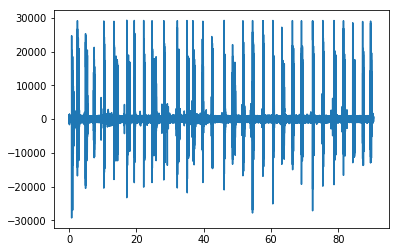

In [3]:
t=np.linspace(0,len(x)/Fs,len(x))
plt.plot(t,x)

## Utils functions

In [4]:
def MySpectrogram(x,ven,inc):
    Nven = math.floor(len(x)/inc) - 1
    Ventanas = np.zeros((Nven,ven))
    Spectrogram = np.zeros((Nven,512))
    ini = 0
    for i in range(Nven):
        Ventanas[i,:]=x[ini:ini+ven]
        ini += inc
        temp = 10*np.log(np.abs(np.fft.fft(Ventanas[i,:],n=1024))**2)
        Spectrogram[i,:]=temp[:512]
    return Spectrogram

def rescaled_signal(x):
    
    scaler = MinMaxScaler()
    
    reshaped_signal = np.reshape(x,(-1,1)).astype(float)
    rescaled_signal = scaler.fit_transform(reshaped_signal)

    original_shape = np.reshape(rescaled_signal,(-1,))
    
    return original_shape

## PyAudioAnalisis Spectogram Function and plot

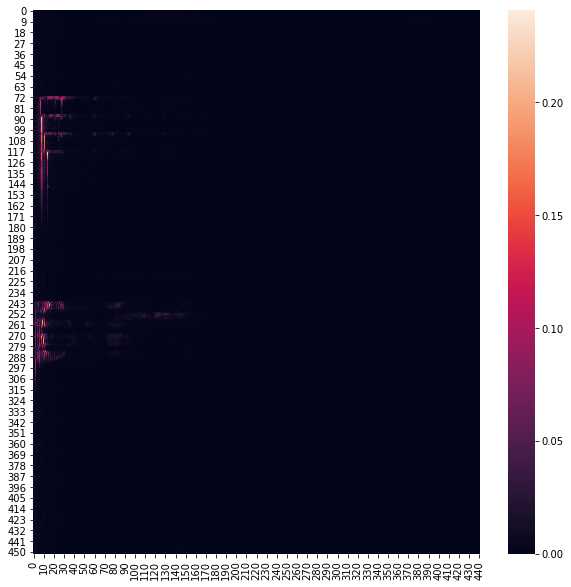

In [5]:
sample_audio_path = os.path.join(params['data_dir'],'audios','Acelera','E-acelera_1.wav')

[fs, x] = audioBasicIO.readAudioFile(sample_audio_path)
x = audioBasicIO.stereo2mono(x)
x = rescaled_signal(x)

specgram, TimeAxis, FreqAxis = audioFeatureExtraction.stSpectogram(
    x[:200000], 
    fs, 
    round(fs * 0.02),
    round(fs * 0.01), 
    False)

fig, axis = plt.subplots(figsize=(10,10))
sns.heatmap(specgram)

## My Spectogram Function and Plot

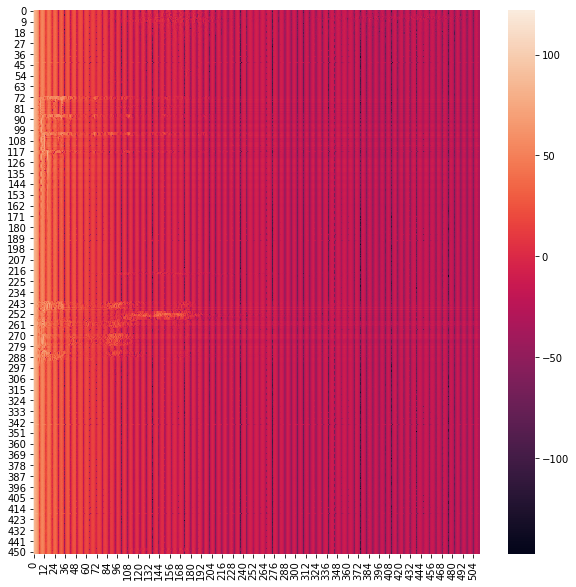

In [6]:
sample_audio_path = os.path.join(params['data_dir'],'audios','Acelera','E-acelera_1.wav')

[fs, x] = audioBasicIO.readAudioFile(sample_audio_path)
x = audioBasicIO.stereo2mono(x)
x = rescaled_signal(x)

Sp = MySpectrogram(x[:200000], round(fs * 0.02),round(fs * 0.01))

fig, axis = plt.subplots(figsize=(10,10))
sns.heatmap(Sp)

## Audios record list

In [16]:
records_list = list()
audios_path = os.path.join(params['data_dir'],'audios')
for root, dirs, files in os.walk(audios_path, topdown=False):
    for name in files:
        records_list.append(os.path.join(root, name))

## Some audio Spectograms

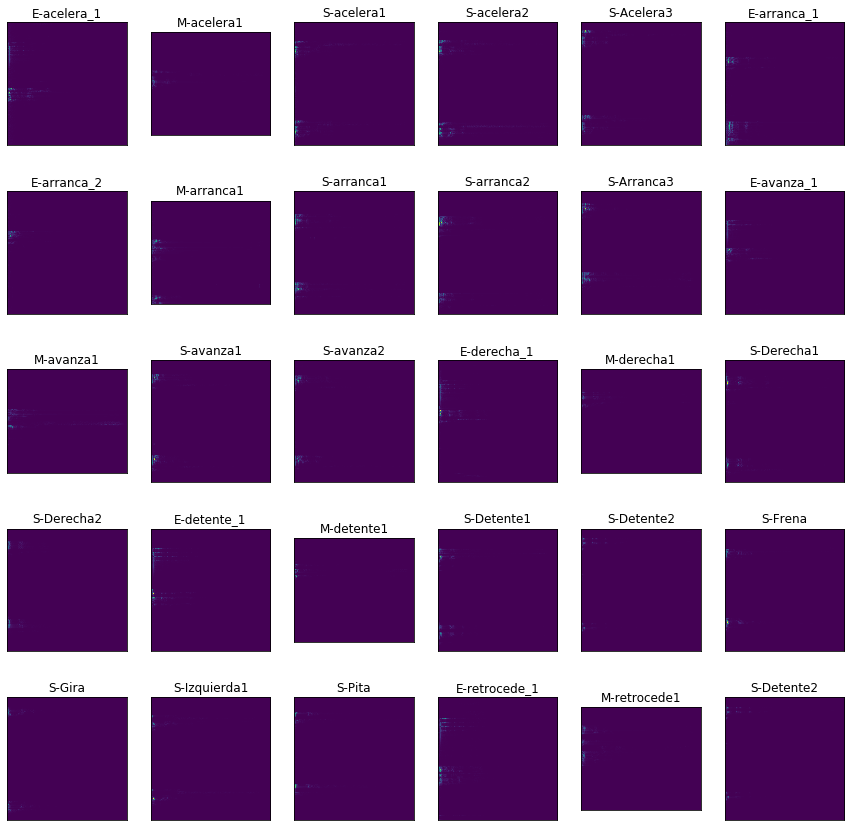

In [40]:
fig, axis = plt.subplots(5,6, figsize=(15,15))
k=0
for i in range(5):
    for j in range(6):
        
        audio = records_list[k]
        
        audio_name = os.path.splitext(audio)[0]
        audio_name = audio_name.split(os.path.sep)[-1]
        
        [fs, x] = audioBasicIO.readAudioFile(audio)
        x = audioBasicIO.stereo2mono(x)
        
        x = rescaled_signal(x)
    
        specgram, TimeAxis, FreqAxis = audioFeatureExtraction.stSpectogram(
            x[:200000], 
            fs, 
            round(fs * 0.02),
            round(fs * 0.01), 
            False
        )
        
        axis[i][j].imshow(specgram)
        axis[i][j].title.set_text(audio_name)
        
        axis[i][j].get_xaxis().set_visible(False)
        axis[i][j].get_yaxis().set_visible(False)
        
        k += 1
plt.show()

# Silence Removal

In [20]:
def _find_Segments_from_audio(x, fs):
        
    segments = audioSegmentation.silenceRemoval(
        x, 
        fs, 
        0.020, 
        0.020, 
        smoothWindow = 1.0, 
        weight = 0.3, 
        plot = False)
    
    return segments

In [57]:
def _extract_audio_fragments(x, fs, segment):
    
    lower_lim, upper_lim = segment
    
    lower_lim = int(lower_lim*fs)
    upper_lim = int(upper_lim*fs)
    
    audio_segment = x[lower_lim:upper_lim]
    
    return audio_segment

## Plot with audio segments

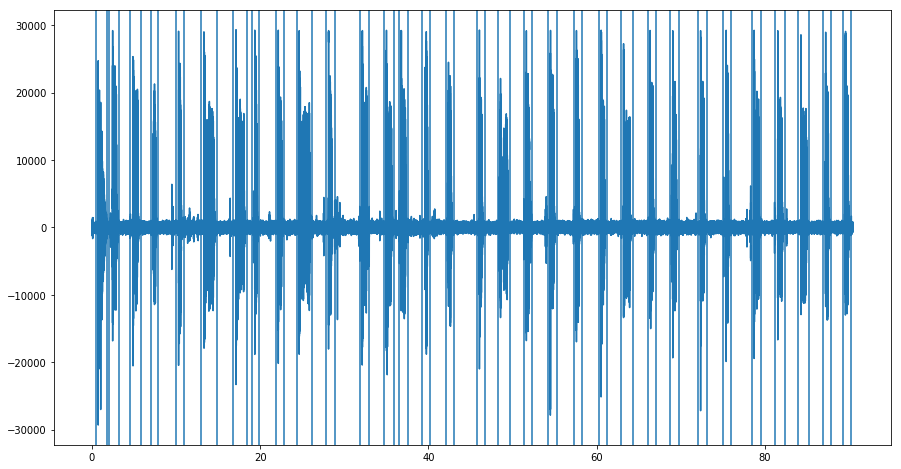

In [22]:
sample_audio_path = os.path.join(params['data_dir'],'audios','Acelera','E-acelera_1.wav')
[Fs, x] = audioBasicIO.readAudioFile(sample_audio_path)
segments = audioSegmentation.silenceRemoval(
    x, 
    Fs, 
    0.020, 
    0.020, 
    smoothWindow = 1.0, 
    weight = 0.3, 
    plot = False)

timeX = np.arange(0, x.shape[0] / float(Fs), 1.0 / Fs)


fig, axis = plt.subplots(1,1,figsize=(15,8))
plt.subplot(1, 1, 1)
plt.plot(timeX, x)
for s in segments:
    plt.axvline(x=s[0])
    plt.axvline(x=s[1])
plt.show()

In [23]:
sample_audio_path = os.path.join(params['data_dir'],'audios','Acelera','E-acelera_1.wav')

[fs, x] = audioBasicIO.readAudioFile(sample_audio_path)


x = audioBasicIO.stereo2mono(x)
x = rescaled_signal(x)

segments = _find_Segments_from_audio(x=x, fs=fs)
audio_fragment = _extract_audio_fragments(x=x, fs=fs, segments=segments)

## Audio Segment Plot

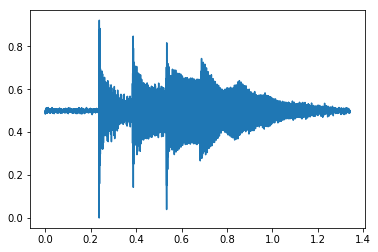

In [24]:
lower_lim, upper_lim = segments[0]

lower_lim = int(lower_lim*fs)
upper_lim = int(upper_lim*fs)

segment_len = len(x[lower_lim:upper_lim])
t=np.linspace(0,segment_len/fs,segment_len)
plt.plot(t, x[lower_lim:upper_lim])

## Spectogram From Audio Segment

(-0.5, 440.5, 132.5, -0.5)

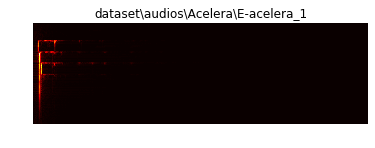

In [25]:
specgram, TimeAxis, FreqAxis = audioFeatureExtraction.stSpectogram(
    audio_fragment, 
    fs, 
    round(fs * 0.02),
    round(fs * 0.01), 
    False
)

audio_name = os.path.splitext(sample_audio_path)[0]

img = plt.imshow(specgram, interpolation='nearest')
img.set_cmap('hot')
plt.title(audio_name)
plt.axis('off')

### For save in local storage the audio dataset

In [66]:
import scipy.io.wavfile
scipy.io.wavfile.write(os.path.join(params['data_dir'],'Test.wav'), fs, x[lower_lim:upper_lim])

## TESTS

In [73]:
audios_list = list()
frequency_list = list()
segments_length = list()

audios_path = os.path.join(params['data_dir'],'audios')
for root, dirs, files in os.walk(audios_path, topdown=False):
    
    for name in files:
        
        fragment_folder = os.path.join(params['data_dir_fragments'],root.split(os.path.sep)[-1])
        
        [fs, x] = audioBasicIO.readAudioFile(os.path.join(root, name))

        x = audioBasicIO.stereo2mono(x)
        x = rescaled_signal(x)

        frequency_list.append(fs)
        audios_list.append(x)

        segments = _find_Segments_from_audio(x=x, fs=fs)
        
        for i,segment in enumerate(segments):
            
            audio_fragment = _extract_audio_fragments(x=x, fs=fs, segment=segment)
            
            if not os.path.exists(fragment_folder):
                os.makedirs(fragment_folder)
            
            name_wav = str(i) + name
            scipy.io.wavfile.write(
                os.path.join(fragment_folder,name_wav),
                fs,
                audio_fragment)
            
            segments_length.append(audio_fragment.shape)

In [112]:
print('Número de palabras:', len(segments_length))
print('Palabra con la longitud más corta:', np.min(segments_length))
print('Palabra con la longitud más larga:', np.max(segments_length))
print('Promedio de longitud de palabra', np.mean(segments_length))

Número de palabras: 896
Palabra con la longitud más corta: 12348
Palabra con la longitud más larga: 440640
Promedio de longitud de palabra 58253.544642857145
